# TC 3006B Inteligencia artificial avanzada para la ciencia de datos I
# CIFAR-10 Data Preparation (PyTorch)
## Feedback

## Deep Learning -- Data Cleaning

### Objective: Load CIFAR-10, explore data, compute per-channel statistics (mean & std), normalize images, and verify normalization.

### Instructions
- Focus on data preparation, analysis, data is not usually as nice as CIFAR10 is. Model training follows as explained in classes.
- Write comments and reflections in the indicated, verify you answer questions in Markdown cells.
- Keep your code clean, reproducible, and well‑commented.



## Environment & Reproducibility


Este código configura el entorno inicial para proyectos de aprendizaje profundo con PyTorch, importando bibliotecas esenciales para manejo de datos, redes neuronales y visualización, estableciendo una semilla (SEED=42) para garantizar reproducibilidad en los resultados, detectando automáticamente si hay GPU disponible para acelerar los cálculos, y preparando el terreno para trabajar con datasets de visión por computadora, siendo típicamente el punto de partida para entrenar modelos de clasificación de imágenes u otras tareas de computer vision.

In [65]:
# Install libraries as needed, if using Colab, maybe all good

import os, json, random, math, time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

##########################################
SEED = 42 #for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
###########################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu



## Download & Load CIFAR-10 (Train/Test Splits)


#### If using Colab you may need the following

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
os.chdir('/content/drive/MyDrive/Inteligencia Artificial/Datasets')

Esta parte del código se encarga de descargar y preparar el dataset CIFAR-10 para su procesamiento, estableciendo primero la ruta de almacenamiento y creando el directorio correspondiente si no existe, luego define una transformación básica que convierte las imágenes en tensores de PyTorch sin normalización ni aumentos de datos aún, y finalmente carga tanto el conjunto de entrenamiento como el de prueba, verificando las dimensiones de los datos para confirmar que se han cargado correctamente los 50,000 ejemplos de entrenamiento y 10,000 de prueba con su formato original de imágenes de 32x32 píxeles y 3 canales de color.

In [58]:
# Maybe obvious, adjust path according to your needs
DATA_DIR = Path("/cifar-10")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Base transform for statistics: convert to tensor only (no normalization/augmentations yet)
base_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=base_transform)
test_set  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=base_transform)

len(train_set), len(test_set), train_set.data.shape


(50000, 10000, (50000, 32, 32, 3))


### Explore de dataset


In [59]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

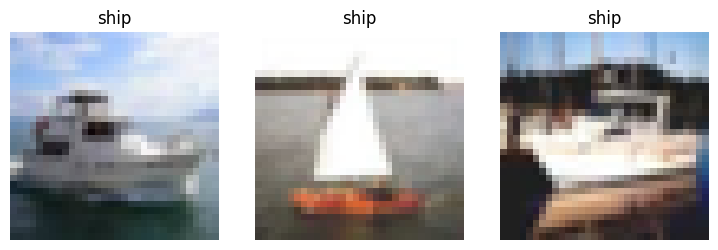

In [60]:
def show_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(n*2.5, 2.5))
    for ax in axes:
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        # img: tensor [C,H,W] in [0,1]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # HWC
        ax.set_title(classes[label])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train_set, n=3)



> **Reflection (Markdown):** Describe CIFAR‑10 (resolution, channels, number of classes/samples). Include one sentence on why normalization is helpful for training.


El dataset CIFAR-10 consta de 60,000 imágenes a color de 32x32 píxeles de resolución con 3 canales (RGB), distribuidas en 10 clases balanceadas (6,000 imágenes por clase), donde 50,000 se destinan para entrenamiento y 10,000 para prueba. La normalización es útil para el entrenamiento porque estabiliza y acelera el proceso de convergencia del modelo al estandarizar el rango de los valores de píxeles, evitando que gradientes demasiado grandes o pequeños dificulten el aprendizaje.


## Compute Per‑Channel Mean & Standard Deviation



Este código calcula la media y la desviación estándar de los canales RGB del dataset CIFAR-10 para su normalización. Primero configura un DataLoader para procesar los datos en lotes de 512 imágenes sin mezclar, optimizado para carga en GPU. La función `compute_mean_std` procesa cada lote aplanando las imágenes de 32x32 píxeles en vectores de 1024 elementos por canal, calcula la media y desviación estándar para cada canal (R, G, B) a través de todos los píxeles y lotes, y finalmente promedia estos valores sobre el total de 50,000 imágenes de entrenamiento. La normalización con estos valores específicos del dataset es crucial porque escala los valores de píxeles a una distribución con media cero y desviación estándar uno, lo que acelera la convergencia del modelo y mejora la estabilidad durante el entrenamiento.

In [61]:
BATCH_SIZE = 512 #Este batch size es el que nos indica, cuántas imágenes vamos a procesar a la vez
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

def compute_mean_std(loader):
    #Primero inicializamos uno tensores (arreglos multidimensionales) para el mean y std
    #Estos tensores tendran una dimensión de 3 una para cada canal de color (RGB)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    #Los samples es la unidad de datos que procesamos, en este caso es una imagen
    #En CIFAR-10 un sample es 1 imágen y 1 etiqueta (avión,etiqueta0)
    total_samples = 0

    # data [batch_size, 3, 32, 32]

    for data, _ in loader:
        batch_samples = data.size(0)  # número de imágenes en el batch

        # Reshape a [batch_size, 3, 32*32] = [batch_size, 3, 1024]
        #Lo que hace el.view es "aplanar" la imagen por ejemplo tenemos una matriz para cada color.
        #y con eso ahora tenemos como un vector grande de n elementos
        #el batch_samples es solo para decirle que vamos a seguir utilizando 512 imágenes
        # el data.size(1) es 3 porque tenemos 3 canales de color
        #data.size(0) = 512  batch size
        #data.size(1) = 3    canales RGB
        #data.size(2) = 32   altura
        #data.size(3) = 32   ancho
        # y el -1 significa que queremos que PyTorch calcule automáticamente el tamaño de esta dimensión y multiplica 32*32
        # es como si tuvieramos (512, 3, 32,32)
        data = data.view(batch_samples, data.size(1), -1)

        # Calcular mean y std por canal
        mean += data.mean(2).sum(0)  # mean sobre píxeles, sum sobre batch
        std += data.std(2).sum(0)    # std sobre píxeles, sum sobre batch

        total_samples += batch_samples

    mean /= total_samples  # Promedio sobre todos los samples
    std /= total_samples   # Promedio sobre todos los samples

    return mean, std

# Usar la función
mean, std = compute_mean_std(train_loader)
mean,std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))


> Record your computed values here (e.g., `Mean ≈ [0.4914, 0.4822, 0.4465]`, `Std ≈ [0.2470, 0.2435, 0.2616]`). Your numbers should closely match these canonical references.



## Normalize Datasets Using Computed Stats


Este código aplica transformaciones de normalización a los conjuntos de entrenamiento y prueba de CIFAR-10 utilizando los valores de media y desviación estándar previamente calculados. Crea pipelines de transformación que primero convierten las imágenes en tensores de PyTorch y luego normalizan cada canal RGB (Red, Green, Blue) restando la media y dividiendo por la desviación estándar correspondiente, lo que resulta en datos con distribución aproximadamente normal (media ≈ 0, desviación ≈ 1). Finalmente, vuelve a cargar los datasets aplicando estas transformaciones, manteniendo el mismo número de muestras (50,000 para entrenamiento y 10,000 para prueba) pero ahora con los valores de píxeles normalizados, lo que optimiza el proceso de entrenamiento de modelos de deep learning al estabilizar la convergencia y mejorar el rendimiento.

In [62]:
# Normalizamos las imágenes usando la media y desv. est. por canal (R, G, B)
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

# Convertimos la imagen a tensor y luego la normalizamos
train_transform = transforms.Compose([
    transforms.ToTensor(), #Imagen a tensor
    normalize, #Emplea la media y desv. est. que calculamos anteriormente
])

#Mismas transformaciones que al conjunto de train
test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

#Ya con el dataset normalizado, vamos a la ruta del CIFAR10, lo seleccionamos y aplicamos las transformaciones
train_set_norm = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=train_transform)
test_set_norm  = datasets.CIFAR10(root=DATA_DIR, train=False, download=False, transform=test_transform)

#Obtener num. de imagenes por conjunto
len(train_set_norm), len(test_set_norm)


(50000, 10000)


## Verify Normalization (Means ≈ 0, Stds ≈ 1)

Confirm the transformation worked as intended.


Este código crea un DataLoader para el conjunto de entrenamiento normalizado de CIFAR-10 y verifica que la normalización se haya aplicado correctamente. El DataLoader configura lotes de 512 imágenes sin mezclar, optimizando la carga de datos con dos subprocesos y transferencia eficiente a la GPU mediante pin_memory. Luego, se recalcula la media y desviación estándar del dataset normalizado, donde los valores resultantes (mean ≈ [0, 0, 0], std ≈ [1, 1, 1]) confirman que la normalización fue exitosa, ya que cada canal RGB ahora tiene una distribución con media cercana a cero y desviación estándar cercana a uno, lo que indica que los datos están adecuadamente escalados para un entrenamiento óptimo del modelo.

In [63]:
#Creamos dataloader para el train normalizado
train_loader_norm = DataLoader(
    train_set_norm,
    batch_size=BATCH_SIZE,
    shuffle=False, #Usamos el dataset completo, no es necesario el shuffle
    num_workers=2, #Cantidad de subprocesos
    pin_memory=True #En caso de correr en un equipo con GPU
    )

#Media y desv. est del conjunto normalizado, que ya debe tener media cerca de 0 y std de 1
mean_norm, std_norm = compute_mean_std(train_loader_norm)
print(f"Mean después de normalización: {mean_norm}")
print(f"Std después de normalización: {std_norm}")

mean_norm, std_norm


Mean después de normalización: tensor([ 3.7207e-07, -3.1963e-07, -2.1301e-07])
Std después de normalización: tensor([1.0000, 1.0000, 1.0000])


(tensor([ 3.7207e-07, -3.1963e-07, -2.1301e-07]),
 tensor([1.0000, 1.0000, 1.0000]))


> Report the post‑normalization means and stds. They should be close to `[0,0,0]` and `[1,1,1]` (small deviations are normal due to rounding/batching).



## Light Data Augmentation
Add a few basic augmentations (random crop with padding, random horizontal flip). Use **train** only.


In [64]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), #Giro horizontal, 50% chance de que ocurra
    transforms.RandomCrop(size=(32, 32), padding=4, padding_mode="reflect"), #Hace un recorte aleatorio sobre una imagen, 4 pixeles de margen
    transforms.ColorJitter(brightness=0.2, contrast=0.3, hue=0.1, saturation = 0.2), #Altera el brillo, contraste, saturación y tono de la imagen, similar a un filtro de edición
    transforms.ToTensor(),
    normalize,
])

#Cargar datos de train con transformaciones aplicadas
train_set_aug = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=aug_transform)
len(train_set_aug)


50000


> Explain when/why augmentation helps. What risks do heavy augmentations pose for small images like CIFAR‑10 (32×32)?


El **aumento de datos (data augmentation)** es útil durante el **entrenamiento de modelos de deep learning** para mejorar la generalización y reducir el sobreajuste (*overfitting*). Se aplica al crear transformaciones aleatorias (como rotaciones, volteos, cambios de color o recortes) en las imágenes de entrenamiento, lo que efectivamente expande el tamaño del dataset sintéticamente y enseña al modelo a ser invariante a variaciones irrelevantes en los datos. Esto es importante hacerlo en conjuntos pequeños como CIFAR-10, donde la reducida cantidad de ejemplos puede llevar a memorización en lugar de aprendizaje.

**Riesgos de aumentos intensos en imágenes pequeñas (32×32):**  
1. **Pérdida de información esencial**: Transformaciones agresivas (como recortes grandes o rotaciones excesivas) pueden eliminar características clave o distorsionar objetos beyond reconocimiento, especialmente en resoluciones bajas donde los detalles ya son limitados.  
2. **Introducción de artefactos**: Operaciones como zoom o rotación pueden generar píxeles artificiales en bordes (efectos de aliasing o borrosidad), añadiendo ruido que confunde al modelo.  
3. **Distorsión de contexto**: En imágenes tan pequeñas, el contexto espacial es crucial; un recorte de unos pocos píxeles puede eliminar partes críticas de un objeto.  
4. **Saturación de deformaciones**: El modelo puede aprender patrones irreales si las transformaciones son demasiado extremas, dañando su capacidad para generalizar a datos reales.  

En conclusión, en CIFAR-10 el aumento debe ser moderado y estratégico (pequeños recortes, volteos horizontales leves, ajustes sutiles de color) para evitar destruir la información ya escasa en imágenes de 32×32.


## Class Distribution
Confirm class balance. CIFAR‑10 should be balanced across the 10 classes. Create a plot as a visual aid



Distribución de clases en: Original
  airplane: 5000
automobile: 5000
      bird: 5000
       cat: 5000
      deer: 5000
       dog: 5000
      frog: 5000
     horse: 5000
      ship: 5000
     truck: 5000


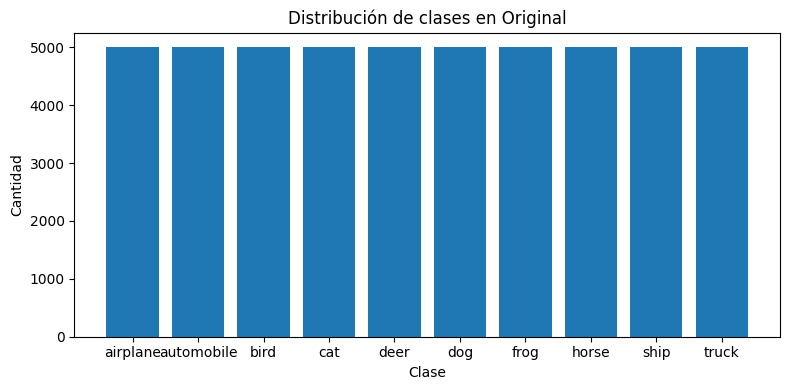


Distribución de clases en: Normalizado
  airplane: 5000
automobile: 5000
      bird: 5000
       cat: 5000
      deer: 5000
       dog: 5000
      frog: 5000
     horse: 5000
      ship: 5000
     truck: 5000


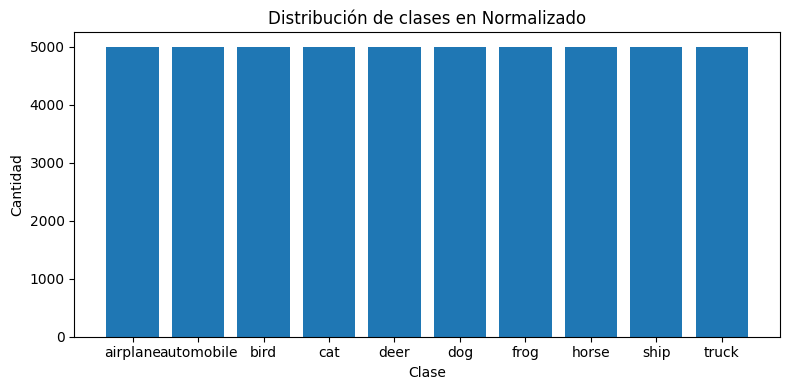


Distribución de clases en: Con Augmentations
  airplane: 5000
automobile: 5000
      bird: 5000
       cat: 5000
      deer: 5000
       dog: 5000
      frog: 5000
     horse: 5000
      ship: 5000
     truck: 5000


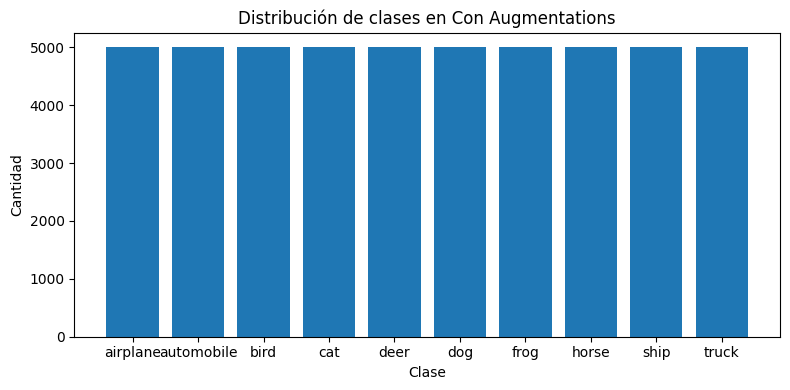

In [66]:
'''
Cifar10 is perfectly distributed among classes, this will not always be the case, plots help, numbers help
'''
train_loader_aug = DataLoader(
    train_set_aug,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

#Lista para comparar
loaders = {
    "Original": train_loader,
    "Normalizado": train_loader_norm,
    "Con Augmentations": train_loader_aug,
}

# show class distribution
for name, loader in loaders.items():
    print(f"\nDistribución de clases en: {name}")
    class_counts = {class_name: 0 for class_name in classes}

    for _, labels in loader:
        for label in labels:
            class_name = classes[label.item()]
            class_counts[class_name] += 1

    # Mostrar conteo por clase
    for class_name, count in class_counts.items():
        print(f"{class_name:>10}: {count}")

# show plot
    plt.figure(figsize=(8,4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.title(f'Distribución de clases en {name}')
    plt.tight_layout()
    plt.show()


## 9. Submission Checklist
- [/] Printed dataset sizes and showed random sample images.
- [/] Reported per‑channel mean & std from the training set.
- [/] Applied normalization using computed stats.
- [/] Verified post‑normalization mean/std are ~0/1.
- [ ] Basic augmentations and rationale.
